# Comparing and Evaluating Clustering Algorithms

### Adjusted Rand Index (ARI)

In [1]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import mglearn
from sklearn.metrics import accuracy_score

Comparing random assignment, k-means, agglomerative clustering, and DBSCAN on the two_moons dataset using the supervised ARI score

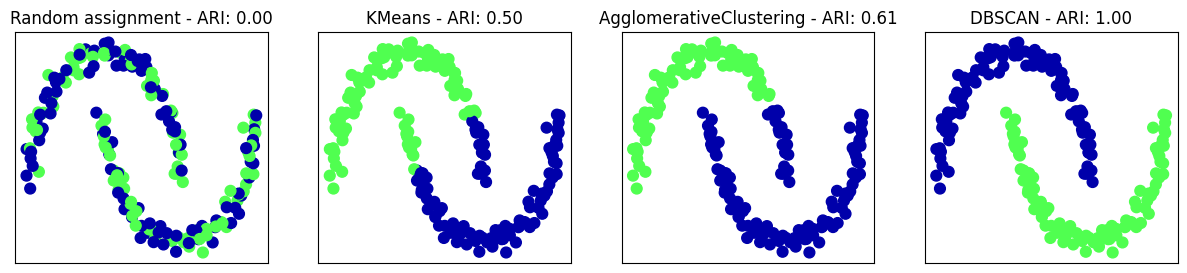

In [2]:
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X) # compute the mean and standard deviation of the data
X_scaled = scaler.transform(X) # rescale the data
fig, axes = plt.subplots(1, 4, figsize=(15, 3),subplot_kw={'xticks': (), 'yticks': ()})
# make a list of algorithms to use
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),DBSCAN()]
# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))
# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
cmap=mglearn.cm3, s=60)
axes[0].set_title("Random assignment - ARI: {:.2f}".format(
adjusted_rand_score(y, random_clusters)))
for ax, algorithm in zip(axes[1:], algorithms):
    # plot the cluster assignments and cluster centers
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters,
    cmap=mglearn.cm3, s=60)
    ax.set_title("{} - ARI: {:.2f}".format(algorithm.__class__.__name__,adjusted_rand_score(y, clusters)))

A common mistake when evaluating clustering in this way is to use `accuracy_score` instead of `adjusted_rand_score`, `normalized_mutual_info_score`, or some other clustering metric. The problem in using accuracy is that it requires the assigned cluster labels to exactly match the ground truth.

In [3]:
# these two labelings of points correspond to the same clustering
clusters1 = [0, 0, 1, 1, 0]
clusters2 = [1, 1, 0, 0, 1]
# accuracy is zero, as none of the labels are the same
print(f"Accuracy: {accuracy_score(clusters1, clusters2):.2f}")
# adjusted rand score is 1, as the clustering is exactly the same
print(f"ARI: {adjusted_rand_score(clusters1, clusters2):.2f}")

Accuracy: 0.00
ARI: 1.00


### Evaluating clustering without ground truth


Comparing random assignment, k-means, agglomerative clustering, andDBSCAN on the two_moons dataset using the unsupervised silhouette score—the more intuitive result of DBSCAN has a lower silhouette score than the assignments found by k-means

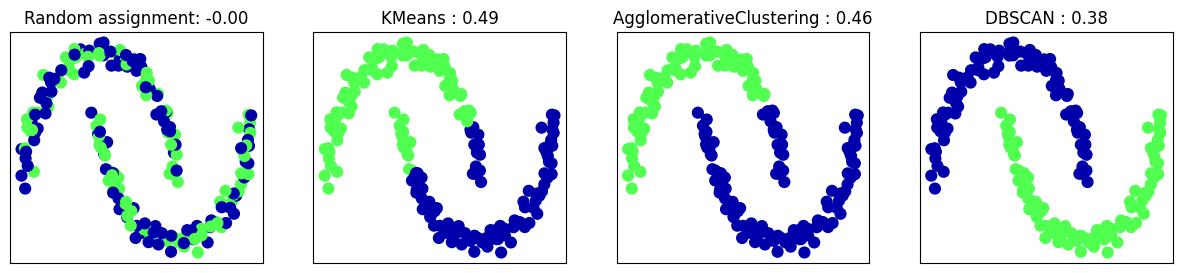

In [4]:
from sklearn.metrics.cluster import silhouette_score
X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
# rescale the data to zero mean and unit variance
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
fig, axes = plt.subplots(1, 4, figsize=(15, 3),
subplot_kw={'xticks': (), 'yticks': ()})
# create a random cluster assignment for reference
random_state = np.random.RandomState(seed=0)
random_clusters = random_state.randint(low=0, high=2, size=len(X))
# plot random assignment
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters,
cmap=mglearn.cm3, s=60)
axes[0].set_title(f"Random assignment: {silhouette_score(X_scaled, random_clusters):.2f}")
algorithms = [KMeans(n_clusters=2), AgglomerativeClustering(n_clusters=2),
DBSCAN()]
for ax, algorithm in zip(axes[1:], algorithms):
    clusters = algorithm.fit_predict(X_scaled)
    # plot the cluster assignments and cluster centers
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap=mglearn.cm3,s=60)
    ax.set_title(f"{algorithm.__class__.__name__} : {silhouette_score(X_scaled, clusters):.2f}")

Even if we get a very robust clustering, or a very high silhouette score, we still don’t know if there is any semantic meaning in the clustering

### Comparing algorithms on the faces dataset

In [5]:
# extract eigenfaces from lfw data and transform data
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
# load the data
people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
X_people = people.data
y_people = people.target
pca = PCA(n_components=100, whiten=True, random_state=0)
pca.fit_transform(X_people)
X_pca = pca.transform(X_people)

In [6]:
# apply DBSCAN with default parameters
dbscan = DBSCAN()
labels = dbscan.fit_predict(X_pca)
print(f"Unique labels: {np.unique(labels)}")

Unique labels: [-1]


We see that all the returned labels are –1, so all of the data was labeled as “noise” by DBSCAN. There are two things we can change to help this: we can make eps higher, to expand the neighborhood of each point, and set min_samples lower, to consider smaller groups of points as clusters. Let’s try changing min_samples first

In [7]:
dbscan = DBSCAN(min_samples=3)
labels = dbscan.fit_predict(X_pca)
print(f"Unique labels: {np.unique(labels)}")

Unique labels: [-1]


In [8]:
dbscan = DBSCAN(min_samples=3, eps=15)
labels = dbscan.fit_predict(X_pca)
print("Unique labels: {}".format(np.unique(labels)))

Unique labels: [-1  0]


Using a much larger eps of 15, we get only a single cluster and noise points. We can use this result to find out what the “noise” looks like compared to the rest of the data

In [9]:
# Count number of points in all clusters and noise.
# bincount doesn't allow negative numbers, so we need to add 1.
# The first number in the result corresponds to noise points.
print(f"Number of points per cluster: {np.bincount(labels + 1)}")

Number of points per cluster: [  26 1262]


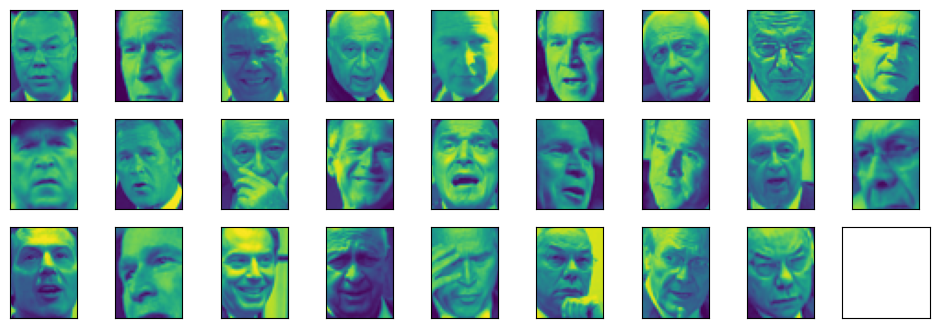

In [10]:
# printing the noise points
noise = X_people[labels==-1]
fig, axes = plt.subplots(3, 9, subplot_kw={'xticks': (), 'yticks': ()},
figsize=(12, 4))
image_shape = people.images.shape[1:]
for image, ax in zip(noise, axes.ravel()):
    ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)

We can see that the noise points have people with their hands in front of their faces, or are not clearly visible. If we want to find more interesting clusters than just one large one, we need to set eps smaller, somewhere between 15 and 0.5 (the default). Let’s have a look at what different values of eps result in:

In [11]:
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X_pca)
    print("Clusters present: {}".format(np.unique(labels)))
    print("Cluster sizes: {}".format(np.bincount(labels + 1)))


eps=1
Clusters present: [-1]
Cluster sizes: [1288]

eps=3
Clusters present: [-1]
Cluster sizes: [1288]

eps=5
Clusters present: [-1]
Cluster sizes: [1288]

eps=7
Clusters present: [-1  0  1  2  3  4  5  6  7  8]
Cluster sizes: [1198   59    3    3    5    4    3    7    3    3]

eps=9
Clusters present: [-1  0  1  2  3]
Cluster sizes: [723 556   3   3   3]

eps=11
Clusters present: [-1  0]
Cluster sizes: [ 262 1026]

eps=13
Clusters present: [-1  0]
Cluster sizes: [  83 1205]


For low settings of eps, all points are labeled as noise. For eps=7, we get many noise points and many smaller clusters. For eps=9 we still get many noise points, but we get one big cluster and some smaller clusters. Starting from eps=11, we get only one large cluster and noise.

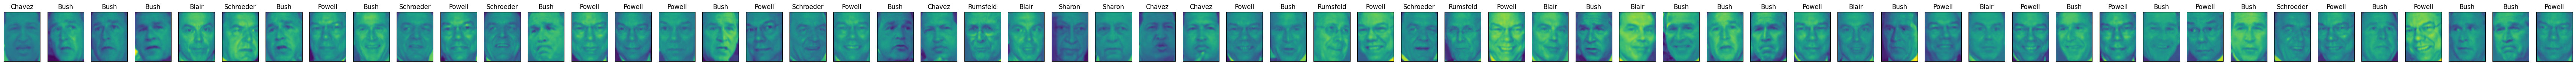

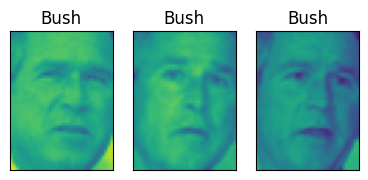

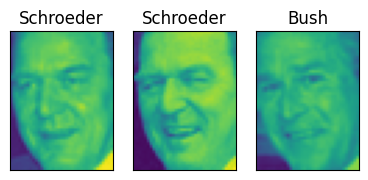

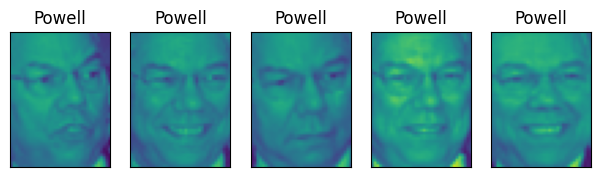

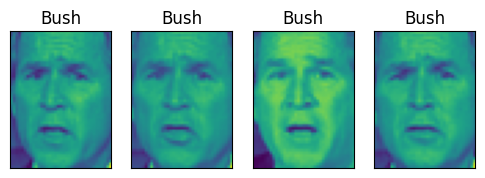

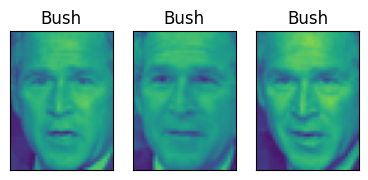

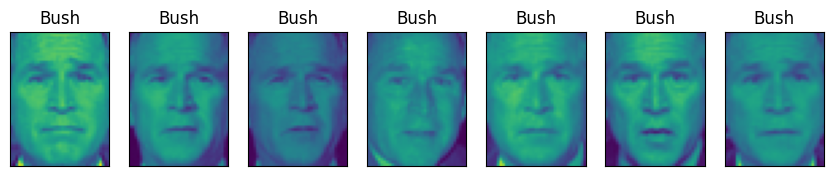

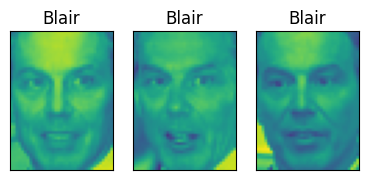

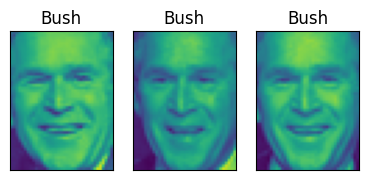

In [ ]:
#Usuing eps=7
dbscan = DBSCAN(min_samples=3, eps=7)
labels = dbscan.fit_predict(X_pca)
for cluster in range(max(labels) + 1):
    mask = labels == cluster
    n_images = np.sum(mask)
    fig, axes = plt.subplots(1, n_images, figsize=(n_images * 1.5, 4),
    subplot_kw={'xticks': (), 'yticks': ()})
    for image, label, ax in zip(X_people[mask], y_people[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1])
        

### Analyzing the faces dataset with k-means

In [13]:
# extract clusters with k-means
km = KMeans(n_clusters=10, random_state=0)
labels_km = km.fit_predict(X_pca)
print("Cluster sizes k-means: {}".format(np.bincount(labels_km)))

Cluster sizes k-means: [  1 109 645 130   1   1 128 170   1 102]


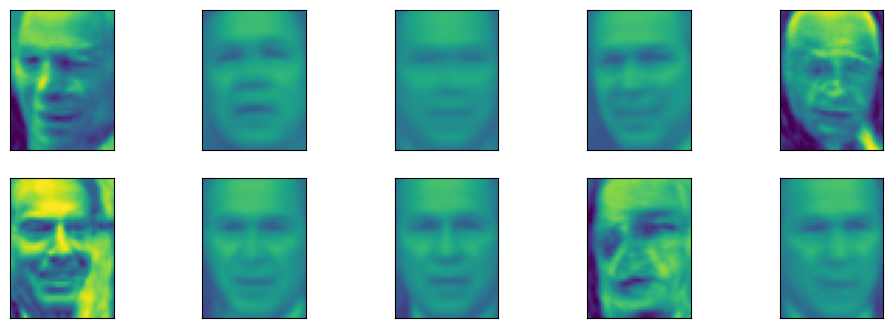

In [14]:
fig, axes = plt.subplots(2, 5, subplot_kw={'xticks': (), 'yticks': ()},
figsize=(12, 4))
for center, ax in zip(km.cluster_centers_, axes.ravel()):
    ax.imshow(pca.inverse_transform(center).reshape(image_shape),vmin=0, vmax=1)

### Analyzing the faces dataset with agglomerative clustering.

In [16]:
# extract clusters with ward agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=10)
labels_agg = agglomerative.fit_predict(X_pca)
print(f"Cluster sizes agglomerative clustering: {np.bincount(labels_agg)}")

Cluster sizes agglomerative clustering: [ 36 444 149 198 122  27 240  11  49  12]


Compute the ARI to measure whether the two partitions of the data given by agglomerative clustering and k-means are similar

In [17]:
print(f"ARI: {adjusted_rand_score(labels_km, labels_agg):.2f}")

ARI: 0.06


Text(0, 0.5, 'Cluster distance')

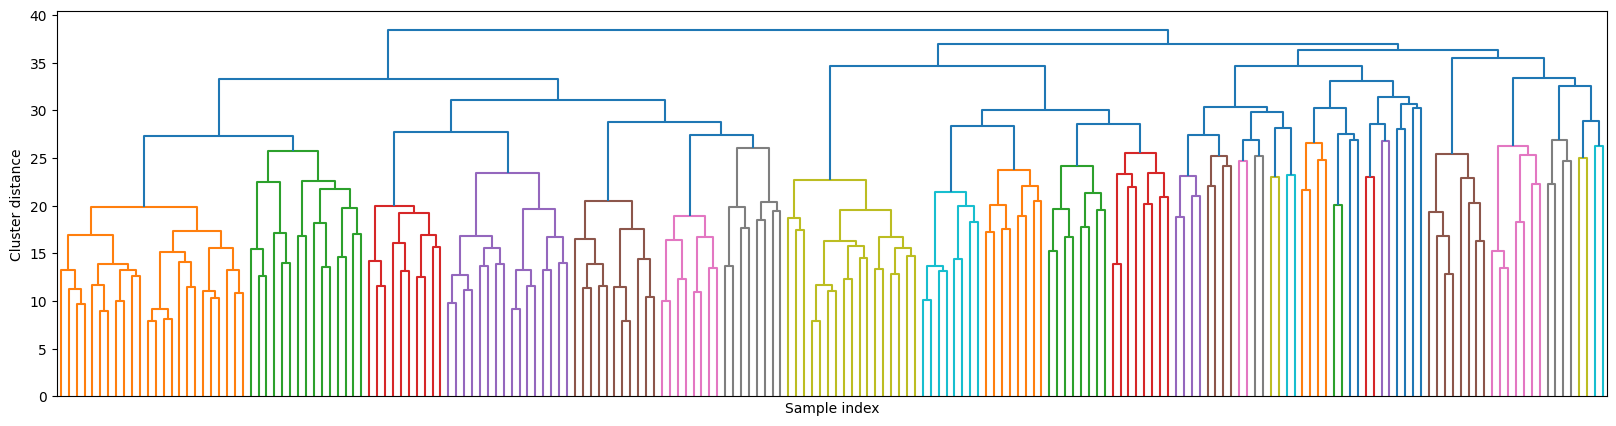

In [18]:
from scipy.cluster.hierarchy import dendrogram, ward
linkage_array = ward(X_pca)
# now we plot the dendrogram for the linkage_array
# containing the distances between clusters
plt.figure(figsize=(20, 5))
dendrogram(linkage_array, p=7, truncate_mode='level', no_labels=True)
plt.xlabel("Sample index")
plt.ylabel("Cluster distance")

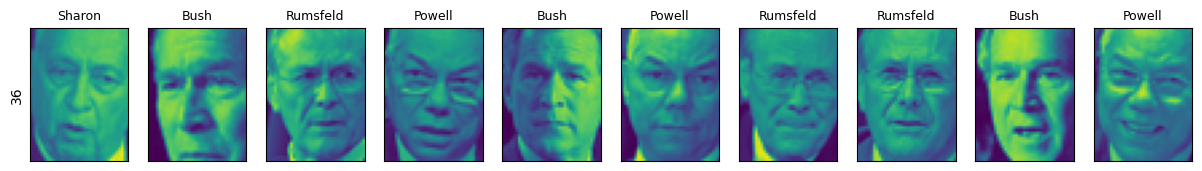

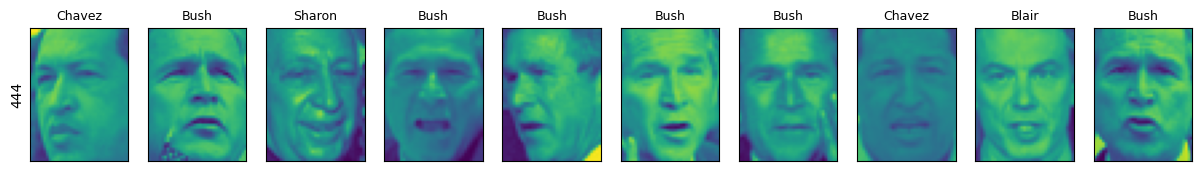

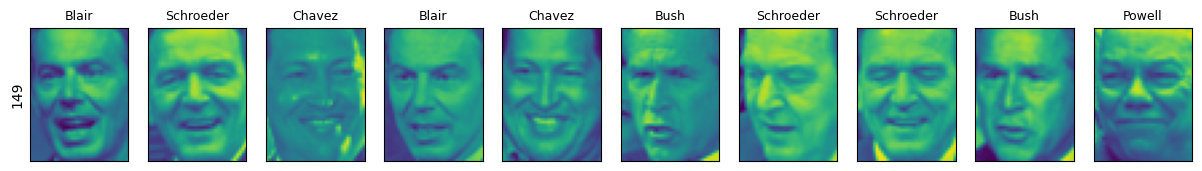

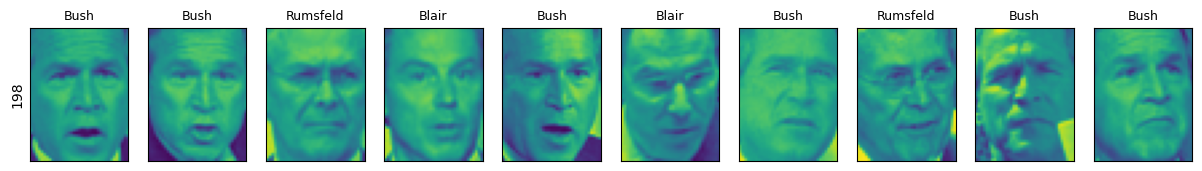

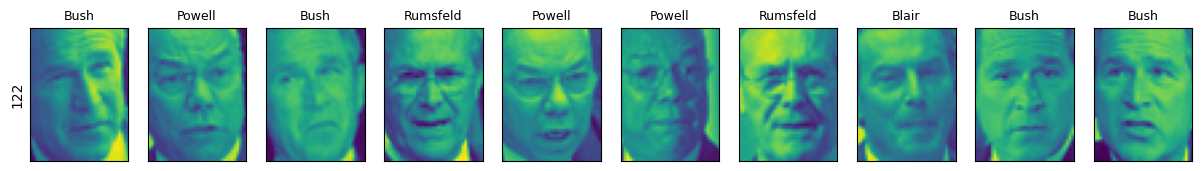

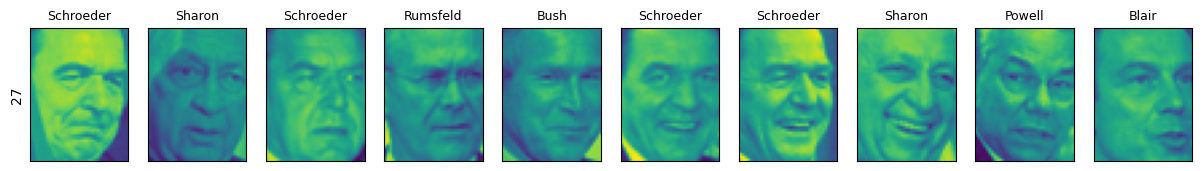

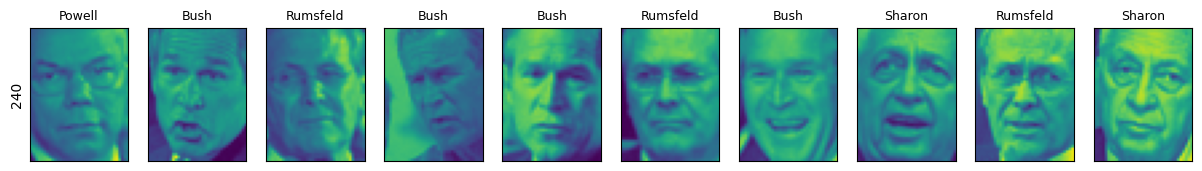

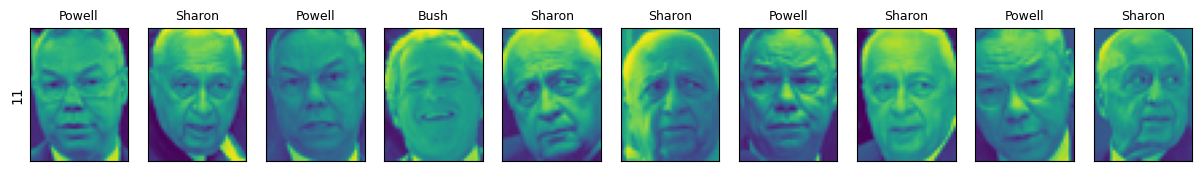

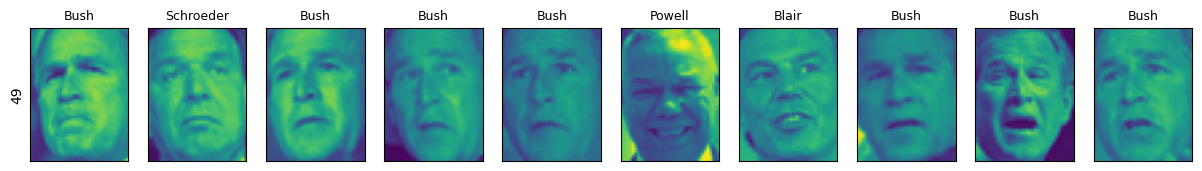

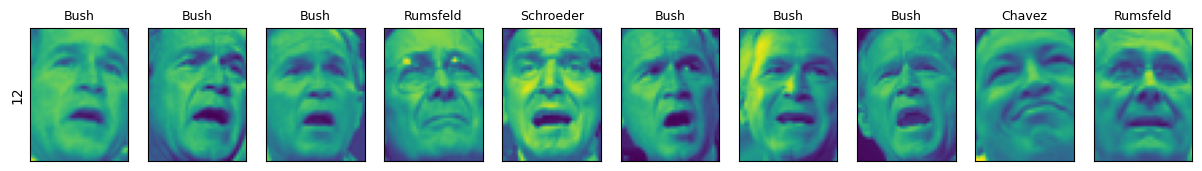

In [ ]:
# Visualize the clusters
n_clusters = 10
for cluster in range(n_clusters):
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 10, subplot_kw={'xticks': (), 'yticks': ()},
    figsize=(15, 8))
    axes[0].set_ylabel(np.sum(mask))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask],
        labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1],fontdict={'fontsize': 9})

Random images from the clusters, each row corre‐sponds to one cluster; the number to the left lists the number of images in each cluster

Now lets run the algorithim with 40 cluster to get some more homegeneous behaviour

cluster sizes agglomerative clustering: [ 11  62  66 111  35  26  39  18  90  12  28  48  18  22  27  50  15  51
 101   4   2  13  15  27  32  22  22  21   5  22  29  31  31  18  27   3
  15 104  14   1]


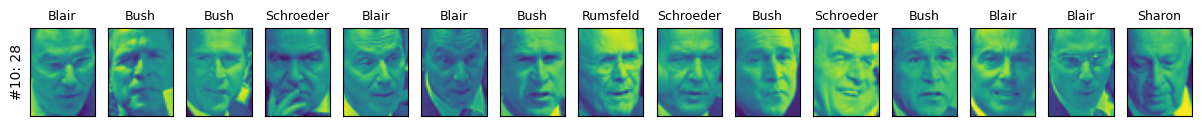

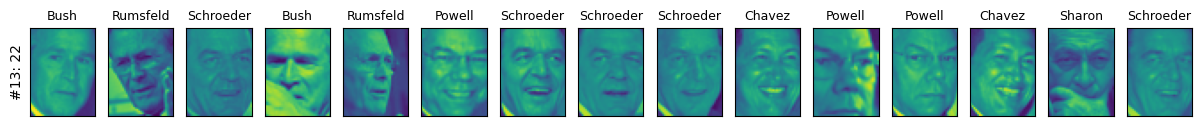

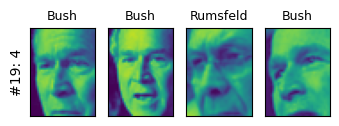

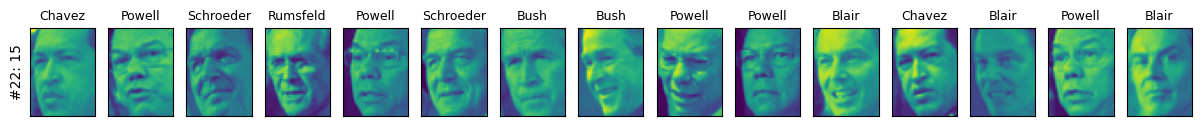

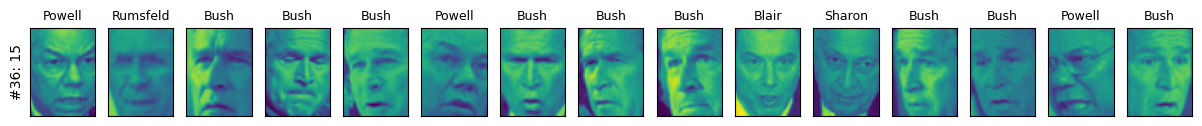

In [21]:
# extract clusters with ward agglomerative clustering
agglomerative = AgglomerativeClustering(n_clusters=40)
labels_agg = agglomerative.fit_predict(X_pca)
print("cluster sizes agglomerative clustering: {}".format(np.bincount(labels_agg)))
n_clusters = 40
for cluster in [10, 13, 19, 22, 36]: # hand-picked "interesting" clusters
    mask = labels_agg == cluster
    fig, axes = plt.subplots(1, 15, subplot_kw={'xticks': (), 'yticks': ()},
    figsize=(15, 8))
    cluster_size = np.sum(mask)
    axes[0].set_ylabel("#{}: {}".format(cluster, cluster_size))
    for image, label, asdf, ax in zip(X_people[mask], y_people[mask],
        labels_agg[mask], axes):
        ax.imshow(image.reshape(image_shape), vmin=0, vmax=1)
        ax.set_title(people.target_names[label].split()[-1],fontdict={'fontsize': 9})
        for i in range(cluster_size, 15):
            axes[i].set_visible(False)